In [ ]:
# Clone the repository containing the LaneNet lane detection implementation
!git clone https://github.com/IrohXu/lanenet-lane-detection-pytorch.git

# Change the current working directory to the cloned repository
%cd lanenet-lane-detection-pytorch

Cloning into 'lanenet-lane-detection-pytorch'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (262/262), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 262 (delta 121), reused 242 (delta 121), pack-reused 0 (from 0)
Receiving objects: 100% (262/262), 20.37 MiB | 25.78 MiB/s, done.
Resolving deltas: 100% (121/121), done.
/content/lanenet-lane-detection-pytorch


## Importing Necessary Libraries

In [ ]:
# Import PyTorch and related modules for deep learning tasks
import torch
import torch.nn as nn

# Import the LaneNet model from the cloned repository
from model.lanenet.LaneNet import LaneNet

# Import optimizers for model training
import torch.optim as optim

# Import torchvision transforms for data preprocessing
import torchvision.transforms as transforms

# Import functional API from PyTorch for various operations
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split # For data handling
# Import PIL for image handling and manipulation
from PIL import Image, ImageDraw
import os   # For file and directory operations
import json # For handling JSON data
import numpy as np  # For numerical operations
import cv2  # For computer vision tasks
from sklearn.metrics import precision_score, recall_score, f1_score # For evaluating model performance
import albumentations as A  # For data augmentation
from albumentations.pytorch import ToTensorV2 # For converting images to PyTorch tensors
from model.lanenet.loss import DiscriminativeLoss, FocalLoss  # Custom loss functions from the cloned repository

In [ ]:
# Initialize the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Path to the pretrained model weights
weights_path = 'log/best_model.pth'

# Instantiate the LaneNet model with ENet as the backbone architecture
model = LaneNet(arch='ENet')

# Load the pretrained weights into the model
model.load_state_dict(torch.load(weights_path, map_location=device))
model.to(device) # Move model to the appropriate device

Use ENet as backbone


LaneNet(
  (_encoder): ENet_Encoder(
    (initial_block): InitialBlock(
      (conv): Sequential(
        (0): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (bottleneck1_0): BottleneckModule(
      (activate): PReLU(num_parameters=1)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(2, 2), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): PReLU(num_p

In [ ]:
# Freeze the parameters of the encoder and binary decoder parts of the model
# This prevents these parts from being updated during training
for param in model._encoder.parameters():
    param.requires_grad = False
for param in model._decoder_binary.parameters():
    param.requires_grad = False

# Set the model and the frozen parts to evaluation mode
# This changes the behavior of certain layers (e.g., dropout, batch norm)
model.eval()
model._encoder.eval()
model._decoder_binary.eval()

# Set the instance decoder part to training mode
# Only this part of the model will be updated during training
model._decoder_instance.train()

ENet_Decoder(
  (bottleneck4_0): BottleneckModule(
    (activate): PReLU(num_parameters=1)
    (maxunpool): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Upsample(scale_factor=2.0, mode='bilinear')
    )
    (conv): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): PReLU(num_parameters=1)
      (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): PReLU(num_parameters=1)
      (9): Dropout2d(p=0, inplace=False)
    )
  )
  (bottleneck4_1): B

In [ ]:
# Import the necessary library to mount Google Drive
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the directories
train_image_dir = '/content/drive/My Drive/Nightdataset/train'
val_image_dir = '/content/drive/My Drive/Nightdataset/val'
test_image_dir = '/content/drive/My Drive/Nightdataset/testdata'

# Function to count image files in a directory
def count_images(directory):
    # List all files in the directory
    files = os.listdir(directory)
    # Count files that are images (e.g., assuming common image extensions)
    image_extensions = ('.jpg', '.jpeg', '.png')
    num_images = sum(1 for f in files if f.lower().endswith(image_extensions))
    return num_images

# Count images in each directory
num_train_images = count_images(train_image_dir)
num_val_images = count_images(val_image_dir)
num_test_images = count_images(test_image_dir)

print(f'Number of training images: {num_train_images}')
print(f'Number of validation images: {num_val_images}')
print(f'Number of test images: {num_test_images}')

Number of training images: 11786
Number of validation images: 664
Number of test images: 625


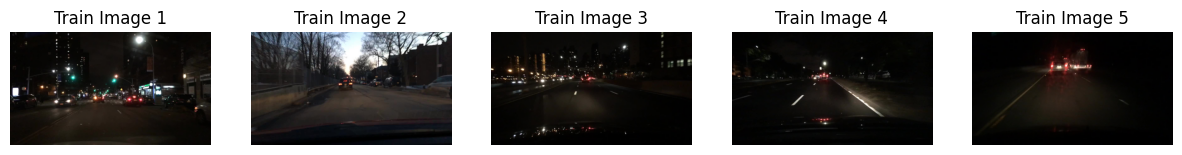

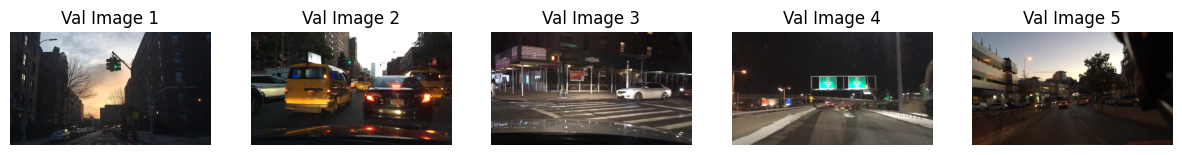

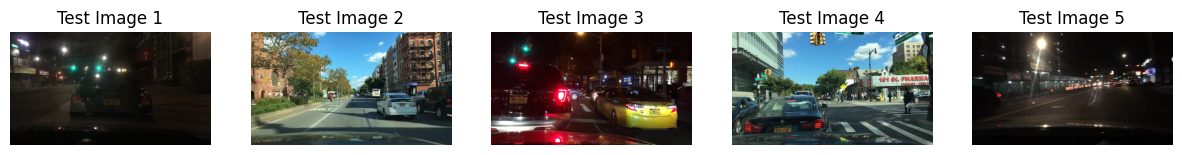

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define directories
train_image_dir = '/content/drive/My Drive/Nightdataset/train'
val_image_dir = '/content/drive/My Drive/Nightdataset/val'
test_image_dir = '/content/drive/My Drive/Nightdataset/testdata'

# Function to get a list of image file paths
def get_image_paths(directory, num_images=5):
    all_files = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    # Return a subset of image file paths
    return [os.path.join(directory, f) for f in all_files[:num_images]]

# Function to display images
def display_images(image_paths, title):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_paths):
        img = mpimg.imread(img_path)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{title} {i + 1}')
    plt.show()

# Get image paths
train_images = get_image_paths(train_image_dir)
val_images = get_image_paths(val_image_dir)
test_images = get_image_paths(test_image_dir)

# Display images
display_images(train_images, 'Train Image')
display_images(val_images, 'Val Image')
display_images(test_images, 'Test Image')


In [ ]:
# Define a custom dataset class for loading and processing lane detection images
class NightLaneDataset(Dataset):
    def __init__(self, image_dir, label_json, transform=None, subset_size=None):
        self.image_dir = image_dir  # Directory containing images
        self.transform = transform  # Data transformation functions

        # Load and parse the JSON file containing image labels and annotations
        with open(label_json, 'r') as f:
            self.label_data = json.load(f)

        # Extract image names and its associated annotations
        self.image_files = [entry['name'] for entry in self.label_data]
        self.annotations = {entry['name']: entry['labels'] for entry in self.label_data}

        # Use only a subset of the data if specified
        if subset_size:
            self.image_files = self.image_files[:subset_size]

    def __len__(self):
        return len(self.image_files)  # Return the total number of samples in the dataset

    def __getitem__(self, idx):
        # Get the image file name and corresponding path
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load the image and convert it to RGB format
        image = np.array(Image.open(img_path).convert("RGB"))

        # Create a blank label image with the same dimensions as the input image
        label = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # Draw lanes on the label image based on annotations
        for annotation in self.annotations[img_name]:
            if annotation['category'] == 'lane' and 'poly2d' in annotation:
                for poly in annotation['poly2d']:
                    vertices = poly['vertices']
                    points = [(int(x), int(y)) for x, y in vertices]
                    cv2.polylines(label, [np.array(points)], isClosed=poly['closed'], color=1, thickness=2)

        # Apply data transformations if specified
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask'].unsqueeze(0)

        return image, label

# Define advanced data transformations using Albumentations
transform = A.Compose([
    A.Resize(256, 512), # Resize images to a consistent size
    A.OneOf([
        A.RandomCrop(256, 512), # Randomly crop images
        A.CenterCrop(256, 512), # Center crop images
    ], p=0.5),
    A.HorizontalFlip(p=0.5),    # Randomly flip images horizontally
    A.OneOf([
        A.RandomBrightnessContrast(p=0.5),  # Randomly adjust brightness and contrast
        A.RandomGamma(p=0.5),               # Randomly adjust gamma
        A.CLAHE(p=0.5),                     # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    ], p=0.5),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),        # Apply blur
        A.GaussianBlur(blur_limit=3, p=0.5), # Apply Gaussian blur
        A.MotionBlur(blur_limit=3, p=0.5),  # Apply motion blur
    ], p=0.5),
    A.HueSaturationValue(p=0.5),            # Randomly adjust hue, saturation, and value
      A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize images
      ToTensorV2()  # Convert images and labels to PyTorch tensors
])

In [ ]:
# Define paths to the training and validation image directories and label JSON files
train_image_dir = '/content/drive/My Drive/Nightdataset/train'
train_label_path = '/content/drive/My Drive/Nightdataset/train_label/train_labels.json'
val_image_dir = '/content/drive/My Drive/Nightdataset/val'
val_label_path = '/content/drive/My Drive/Nightdataset/val_label/val_labels.json'


# Create instances of the NightLaneDataset for training and validation
# The transform parameter applies the defined transformations to the datasets
train_dataset = NightLaneDataset(train_image_dir, train_label_path, transform=transform)
val_dataset = NightLaneDataset(val_image_dir, val_label_path, transform=transform)

# Create DataLoader objects for the training and validation datasets
# The DataLoader handles batching and shuffling of the data
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Verify the dataset and dataloader setup
# This loop checks the sizes of the image and label tensors
for images, labels in train_loader:
    print(images.size(), labels.size())  # Ensure all tensors are of the same size
    break

torch.Size([16, 3, 256, 512]) torch.Size([16, 1, 256, 512])


## Model Training

In [ ]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load the optimizer state if resuming from a checkpoint
if os.path.exists(checkpoint_path):
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set the model to training mode
model.train()

# Define the discriminative loss function for instance segmentation
# The loss function encourages the network to separate different instances in the feature space
discriminative_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=1.5, norm=2, alpha=1.0, beta=1.0, gamma=0.001)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to compute evaluation metrics: precision, recall, and F1-score
def compute_metrics(preds, labels):
    # Flatten predictions and labels to 1D arrays
    preds = preds.view(-1).cpu().numpy()
    labels = labels.view(-1).cpu().numpy()

    # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    return precision, recall, f1


In [ ]:
# Training and Validation Functions

# Define the function to save checkpoints with unique filenames
def save_checkpoint(model, optimizer, epoch, base_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    filepath = f"{base_path}_epoch_{epoch+1}.pth"
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at {filepath}")


# Training function with checkpoint saving
def train_model_with_checkpoints(model, train_loader, val_loader, optimizer, num_epochs=10, start_epoch=0, checkpoint_path='/content/drive/My Drive/Nightdataset/models/checkpoint.pth'):
    best_iou = 0  # Initialize the best Intersection over Union (IoU) score

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_precision, total_recall, total_f1 = 0.0, 0.0, 0.0
        model._decoder_instance.train()  # Ensure the instance decoder is in training mode

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).squeeze(1).long()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass through the model
            output = model(images)
            instance_seg_logits = output['instance_seg_logits']

            # Calculate loss using the discriminative loss function
            var_loss, dist_loss, reg_loss = discriminative_loss(instance_seg_logits, labels)
            instance_loss = var_loss + dist_loss
            loss = instance_loss

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate metrics: precision, recall, and F1 score
            preds = torch.argmax(F.softmax(instance_seg_logits, dim=1), dim=1)
            precision, recall, f1 = compute_metrics(preds, labels)
            total_precision += precision
            total_recall += recall
            total_f1 += f1

        # Calculate average metrics for the epoch
        epoch_loss = running_loss / len(train_loader)
        avg_precision = total_precision / len(train_loader)
        avg_recall = total_recall / len(train_loader)
        avg_f1 = total_f1 / len(train_loader)

        # Print training metrics for the current epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
              f'Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1 Score: {avg_f1:.4f}')

        # Validate the model on the validation set
        val_loss, val_iou, val_precision, val_recall, val_f1 = validate_model(model, val_loader)
        print(f'Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}, '
              f'Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, '
              f'Validation F1 Score: {val_f1:.4f}')

        # Save checkpoint at the end of each epoch
        save_checkpoint(model, optimizer, epoch, checkpoint_path)

    print('Training complete')
    return model

# Validation function with IoU calculation
def validate_model(model, val_loader):
    model._decoder_instance.eval()  # Set the instance decoder to evaluation mode
    val_loss = 0.0
    total_iou = 0.0
    total_precision, total_recall, total_f1 = 0.0, 0.0, 0.0
    num_batches = len(val_loader)

    with torch.no_grad(): # Disable gradient calculation for validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.squeeze(1).to(device).long()

            # Forward pass
            output = model(images)
            instance_seg_logits = output['instance_seg_logits']

            # Calculate the loss
            var_loss, dist_loss, reg_loss = discriminative_loss(instance_seg_logits, labels)
            instance_loss = var_loss + dist_loss
            loss = instance_loss

            val_loss += instance_loss.item()

            # Calculate IoU for instance segmentation
            preds = torch.argmax(F.softmax(instance_seg_logits, dim=1), dim=1)
            intersection = ((preds == 1) & (labels == 1)).float().sum((1, 2))
            union = ((preds == 1) | (labels == 1)).float().sum((1, 2))
            iou = (intersection / (union + 1e-6)).mean().item()
            total_iou += iou

            # Calculate the evaluation metrics: precision, recall, and F1 score
            precision, recall, f1 = compute_metrics(preds, labels)
            total_precision += precision
            total_recall += recall
            total_f1 += f1

    # Calculate average validation metrics
    avg_val_loss = val_loss / num_batches
    avg_iou = total_iou / num_batches
    avg_precision = total_precision / num_batches
    avg_recall = total_recall / num_batches
    avg_f1 = total_f1 / num_batches

    model.train() # Set the model back to training mode
    return avg_val_loss, avg_iou, avg_f1, avg_recall, avg_precision

# Train the model with the specified number of epochs
num_epochs = 10
trained_model = train_model_with_checkpoints(model, train_loader, val_loader, optimizer, num_epochs=num_epochs)

# Save the final trained model's state dictionary
torch.save(trained_model.state_dict(), '/content/drive/My Drive/Nightdataset/models/mytrained_lanenet_decoder_instance1.pth')

Epoch 1/10, Loss: 0.1859, Precision: 0.3423, Recall: 0.4015, F1 Score: 0.2763
Validation Loss: 0.1708, Validation IoU: 0.0366, Validation Precision: 0.2817, Validation Recall: 0.4396, Validation F1 Score: 0.3450
Checkpoint saved at /content/drive/My Drive/Nightdataset/models/checkpoint.pth_epoch_1.pth
Epoch 2/10, Loss: 0.1662, Precision: 0.3429, Recall: 0.3841, F1 Score: 0.2812
Validation Loss: 0.1470, Validation IoU: 0.0396, Validation Precision: 0.2960, Validation Recall: 0.3783, Validation F1 Score: 0.3466
Checkpoint saved at /content/drive/My Drive/Nightdataset/models/checkpoint.pth_epoch_2.pth
Epoch 3/10, Loss: 0.1594, Precision: 0.3431, Recall: 0.3729, F1 Score: 0.2822
Validation Loss: 0.1516, Validation IoU: 0.0367, Validation Precision: 0.2876, Validation Recall: 0.4200, Validation F1 Score: 0.3456
Checkpoint saved at /content/drive/My Drive/Nightdataset/models/checkpoint.pth_epoch_3.pth
Epoch 4/10, Loss: 0.1541, Precision: 0.3428, Recall: 0.3664, F1 Score: 0.2831
Validation Lo

In [ ]:
# Load the trained model
model = LaneNet(arch='ENet')
model.load_state_dict(torch.load('/content/drive/My Drive/Nightdataset/models/mytrained_lanenet_decoder_instance1.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

Use ENet as backbone


LaneNet(
  (_encoder): ENet_Encoder(
    (initial_block): InitialBlock(
      (conv): Sequential(
        (0): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (bottleneck1_0): BottleneckModule(
      (activate): PReLU(num_parameters=1)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(2, 2), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): PReLU(num_p

## Fine-tuned Model Testing

In [ ]:
# Define the test dataset and DataLoader
test_image_dir = '/content/drive/My Drive/Nightdataset/testdata'
test_label_path = '/content/drive/My Drive/Nightdataset/test_label/test_label.json'

# Instantiate the test dataset with the defined transformations
test_dataset = NightLaneDataset(test_image_dir, test_label_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
# Function to test the model and save results
def test_model(model, test_loader, save_path):
    total_precision, total_recall, total_f1 = 0.0, 0.0, 0.0
    total_iou = 0.0
    total_accuracy = 0.0
    num_batches = len(test_loader)
    all_predictions = []  # Initialize list to store all predictions
    all_labels = []       # Initialize list to store all labels
    all_metrics = []      # Initialize list to store all batch metrics

    # Disable gradient computation for testing (inference)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.squeeze(1).to(device).long()

            # Forward pass through the model to get predictions
            output = model(images)
            instance_seg_logits = output['instance_seg_logits']

            # Convert logits to class predictions
            preds = torch.argmax(F.softmax(instance_seg_logits, dim=1), dim=1)

            # Store predictions and labels for further analysis
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calculate evaluation metrics: precision, recall, and F1 score
            precision, recall, f1 = compute_metrics(preds, labels)
            total_precision += precision
            total_recall += recall
            total_f1 += f1

            # Store metrics for each batch
            all_metrics.append({
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            })

            # Calculate IoU (Intersection over Union) for instance segmentation
            intersection = ((preds == 1) & (labels == 1)).float().sum((1, 2))
            union = ((preds == 1) | (labels == 1)).float().sum((1, 2))
            iou = (intersection / (union + 1e-6)).mean().item()
            total_iou += iou

            # Accuracy calculation
            accuracy = (preds == labels).float().mean().item()
            total_accuracy += accuracy

    # Calculate average metrics over all batches
    avg_precision = total_precision / num_batches
    avg_recall = total_recall / num_batches
    avg_f1 = total_f1 / num_batches
    avg_iou = total_iou / num_batches
    avg_accuracy = total_accuracy / num_batches

    # Print the final evaluation metrics
    print(f'Test Precision: {avg_precision:.4f}')
    print(f'Test Recall: {avg_recall:.4f}')
    print(f'Test F1 Score: {avg_f1:.4f}')
    print(f'Test IoU: {avg_iou:.4f}')
    print(f'Test Accuracy: {avg_accuracy:.4f}')

    # Save the model state
    torch.save(model.state_dict(), f"{save_path}_final_model.pth")
    print(f"Model state saved at {save_path}_final_model.pth")

    # Save predictions and labels for further analysis
    np.save(f"{save_path}_predictions.npy", all_predictions)
    np.save(f"{save_path}_labels.npy", all_labels)
    print(f"Predictions and labels saved at {save_path}_predictions.npy and {save_path}_labels.npy")

    # Save detailed metrics
    detailed_metrics = {
        "average_precision": avg_precision,
        "average_recall": avg_recall,
        "average_f1_score": avg_f1,
        "average_iou": avg_iou,
        "average_accuracy": avg_accuracy,
        "batch_metrics": all_metrics
    }
    with open(f"{save_path}_metrics.json", "w") as f:
        json.dump(detailed_metrics, f)
    print(f"Metrics saved at {save_path}_metrics.json")

# Example usage
save_path = "/content/drive/My Drive/Nightdataset/test_results"
test_model(model, test_loader, save_path)

Test Precision: 0.3441
Test Recall: 0.3789
Test F1 Score: 0.2869
Test IoU: 0.0307
Test Accuracy: 0.6652
Model state saved at /content/drive/My Drive/Nightdataset/test_results_final_model.pth
Predictions and labels saved at /content/drive/My Drive/Nightdataset/test_results_predictions.npy and /content/drive/My Drive/Nightdataset/test_results_labels.npy
Metrics saved at /content/drive/My Drive/Nightdataset/test_results_metrics.json


## Loading the Original Model

In [ ]:
# Import PyTorch and related modules for deep learning tasks
import torch
import torch.nn as nn

# Import the LaneNet model from the cloned repository
from model.lanenet.LaneNet import LaneNet

# Import optimizers for model training
import torch.optim as optim

# Import torchvision transforms for data preprocessing
import torchvision.transforms as transforms

# Import functional API from PyTorch for various operations
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split # For data handling
# Import PIL for image handling and manipulation
from PIL import Image, ImageDraw
import os   # For file and directory operations
import json # For handling JSON data
import numpy as np  # For numerical operations
import cv2  # For computer vision tasks
from sklearn.metrics import precision_score, recall_score, f1_score # For evaluating model performance
import albumentations as A  # For data augmentation
from albumentations.pytorch import ToTensorV2 # For converting images to PyTorch tensors
from model.lanenet.loss import DiscriminativeLoss, FocalLoss  # Custom loss functions from the cloned repository

In [ ]:
# Mount Google Drive, if using Colab, to save checkpoints and other files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path where checkpoints will be saved
checkpoint_dir = '/content/drive/My Drive/Nightdataset/original_model'

In [ ]:
# Unfreeze all layers to ensure they are trainable
for param in model.parameters():
    param.requires_grad = True


In [ ]:
# Define paths to the image directories and label JSON files for training and validation
train_image_dir = '/content/drive/My Drive/Nightdataset/train'
train_label_path = '/content/drive/My Drive/Nightdataset/train_label/train_labels.json'
val_image_dir = '/content/drive/My Drive/Nightdataset/val'
val_label_path = '/content/drive/My Drive/Nightdataset/val_label/val_labels.json'


In [ ]:
# Define data transformations
transform = A.Compose([
    A.Resize(256, 512),
    A.OneOf([
        A.RandomCrop(256, 512),
        A.CenterCrop(256, 512)
    ], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.5),
        A.CLAHE(p=0.5)
    ], p=0.5),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),
        A.GaussianBlur(blur_limit=3, p=0.5),
        A.MotionBlur(blur_limit=3, p=0.5)
    ], p=0.5),
    A.HueSaturationValue(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Create dataset instances
train_dataset = NightLaneDataset(train_image_dir, train_label_path, transform=transform)
val_dataset = NightLaneDataset(val_image_dir, val_label_path, transform=transform)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
# Define the path to the pretrained model weights
weights_path = 'log/best_model.pth'

# Instantiate the LaneNet model with the desired backbone architecture (ENet in this case)
model = LaneNet(arch='ENet')

# Load the pretrained weights into the model
model.load_state_dict(torch.load(weights_path, map_location=device))

# Move the model to the appropriate device (GPU or CPU)
model.to(device)

Use ENet as backbone


LaneNet(
  (_encoder): ENet_Encoder(
    (initial_block): InitialBlock(
      (conv): Sequential(
        (0): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (bottleneck1_0): BottleneckModule(
      (activate): PReLU(num_parameters=1)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(2, 2), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): PReLU(num_p

## Training the original model

In [ ]:
# Define the optimizer to update all model parameters
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function(s)
discriminative_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=1.5, norm=2, alpha=1.0, beta=1.0, gamma=0.001)

In [ ]:
# Function to compute metrics
def compute_metrics(preds, labels):
    preds = preds.view(-1).cpu().numpy()
    labels = labels.view(-1).cpu().numpy()
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    return precision, recall, f1

# Function to validate the model
def validate_model(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    total_iou = 0.0
    total_precision, total_recall, total_f1 = 0.0, 0.0, 0.0
    num_batches = len(val_loader)

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.squeeze(1).to(device).long()

            # Forward pass
            output = model(images)
            instance_seg_logits = output['instance_seg_logits']

            # Calculate the loss
            var_loss, dist_loss, reg_loss = discriminative_loss(instance_seg_logits, labels)
            instance_loss = var_loss + dist_loss
            val_loss += instance_loss.item()

            # Calculate IoU for instance segmentation
            preds = torch.argmax(F.softmax(instance_seg_logits, dim=1), dim=1)
            intersection = ((preds == 1) & (labels == 1)).float().sum((1, 2))
            union = ((preds == 1) | (labels == 1)).float().sum((1, 2))
            iou = (intersection / (union + 1e-6)).mean().item()
            total_iou += iou

            # Calculate metrics: precision, recall, and F1 score
            precision, recall, f1 = compute_metrics(preds, labels)
            total_precision += precision
            total_recall += recall
            total_f1 += f1

    # Calculate average validation metrics
    avg_val_loss = val_loss / num_batches
    avg_iou = total_iou / num_batches
    avg_precision = total_precision / num_batches
    avg_recall = total_recall / num_batches
    avg_f1 = total_f1 / num_batches

    model.train()  # Set the model back to training mode
    return avg_val_loss, avg_iou, avg_f1, avg_recall, avg_precision

# Define the training loop function
def train_full_model(model, train_loader, val_loader, optimizer, num_epochs=10, checkpoint_dir=checkpoint_dir):
    best_iou = 0  # Initialize the best IoU score

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_precision, total_recall, total_f1 = 0.0, 0.0, 0.0
        total_iou = 0.0
        model.train()  # Set the model to training mode

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).squeeze(1).long()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass through the model
            output = model(images)
            instance_seg_logits = output['instance_seg_logits']

            # Calculate the loss using the discriminative loss function
            var_loss, dist_loss, reg_loss = discriminative_loss(instance_seg_logits, labels)
            instance_loss = var_loss + dist_loss
            loss = instance_loss

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate metrics: precision, recall, and F1 score
            preds = torch.argmax(F.softmax(instance_seg_logits, dim=1), dim=1)
            precision, recall, f1 = compute_metrics(preds, labels)
            total_precision += precision
            total_recall += recall
            total_f1 += f1

            # Calculate IoU (Intersection over Union)
            intersection = ((preds == 1) & (labels == 1)).float().sum((1, 2))
            union = ((preds == 1) | (labels == 1)).float().sum((1, 2))
            iou = (intersection / (union + 1e-6)).mean().item()
            total_iou += iou

        # Calculate average metrics for the epoch
        avg_precision = total_precision / len(train_loader)
        avg_recall = total_recall / len(train_loader)
        avg_f1 = total_f1 / len(train_loader)
        avg_iou = total_iou / len(train_loader)

        # Print training metrics for the current epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, '
              f'Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1 Score: {avg_f1:.4f}, IoU: {avg_iou:.4f}')

        # Validate the model
        avg_val_loss, avg_val_iou, avg_val_f1, avg_val_recall, avg_val_precision = validate_model(model, val_loader)
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation IoU: {avg_val_iou:.4f}, '
              f'Validation Precision: {avg_val_precision:.4f}, Validation Recall: {avg_val_recall:.4f}, '
              f'Validation F1 Score: {avg_val_f1:.4f}')

        # Save a checkpoint at the end of each epoch with a unique filename
        checkpoint_path = f"{checkpoint_dir}/original_model_checkpoint_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, checkpoint_path)
        print(f'Checkpoint saved at {checkpoint_path}')

    print('Full model training complete.')

# Start the training process
train_full_model(model, train_loader, val_loader, optimizer, num_epochs=10)

# Save the original trained model's state dictionary
torch.save(model.state_dict(), '/content/drive/My Drive/Nightdataset/original_model/original_trained_model.pth')

Epoch 1/10, Loss: 0.1088, Precision: 0.3409, Recall: 0.4377, F1 Score: 0.2969, IoU: 0.0233
Validation Loss: 0.0776, Validation IoU: 0.0381, Validation Precision: 0.3461, Validation Recall: 0.4272, Validation F1 Score: 0.3199
Checkpoint saved at /content/drive/My Drive/Nightdataset/original_model/original_model_checkpoint_epoch_1.pth
Epoch 2/10, Loss: 0.0753, Precision: 0.3422, Recall: 0.3884, F1 Score: 0.3105, IoU: 0.0271
Validation Loss: 0.0658, Validation IoU: 0.0350, Validation Precision: 0.3452, Validation Recall: 0.3903, Validation F1 Score: 0.3194
Checkpoint saved at /content/drive/My Drive/Nightdataset/original_model/original_model_checkpoint_epoch_2.pth
Epoch 3/10, Loss: 0.0625, Precision: 0.3443, Recall: 0.4111, F1 Score: 0.3203, IoU: 0.0337
Validation Loss: 0.0575, Validation IoU: 0.0410, Validation Precision: 0.3473, Validation Recall: 0.4308, Validation F1 Score: 0.3285
Checkpoint saved at /content/drive/My Drive/Nightdataset/original_model/original_model_checkpoint_epoch_3

NameError: name 'trained_model' is not defined

In [ ]:
# Save the original trained model's state dictionary
torch.save(model.state_dict(), '/content/drive/My Drive/Nightdataset/original_model/original_trained_model.pth')

##Original Model Testing

In [ ]:
# Define the test dataset and DataLoader
test_image_dir = '/content/drive/My Drive/Nightdataset/testdata'
test_label_path = '/content/drive/My Drive/Nightdataset/test_label/test_label.json'

# Instantiate the test dataset with the defined transformations
test_dataset = NightLaneDataset(test_image_dir, test_label_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Function to test the model and save results
def test_model(model, test_loader, save_path):
    model.eval()  # Set model to evaluation mode
    total_precision, total_recall, total_f1 = 0.0, 0.0, 0.0
    total_iou = 0.0
    total_accuracy = 0.0
    num_batches = len(test_loader)

    all_predictions = []
    all_labels = []
    all_metrics = []

    # Disable gradient computation for testing (inference)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.squeeze(1).to(device).long()

            # Forward pass through the model to get predictions
            output = model(images)
            instance_seg_logits = output['instance_seg_logits']

            # Convert logits to class predictions
            preds = torch.argmax(F.softmax(instance_seg_logits, dim=1), dim=1)

            # Store predictions and labels for further analysis
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calculate evaluation metrics: precision, recall, and F1 score
            precision, recall, f1 = compute_metrics(preds, labels)
            total_precision += precision
            total_recall += recall
            total_f1 += f1

            # Store metrics for each batch
            all_metrics.append({
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            })

            # Calculate IoU (Intersection over Union) for instance segmentation
            intersection = ((preds == 1) & (labels == 1)).float().sum((1, 2))
            union = ((preds == 1) | (labels == 1)).float().sum((1, 2))
            iou = (intersection / (union + 1e-6)).mean().item()
            total_iou += iou

            # Accuracy calculation
            accuracy = (preds == labels).float().mean().item()
            total_accuracy += accuracy

    # Calculate average metrics over all batches
    avg_precision = total_precision / num_batches
    avg_recall = total_recall / num_batches
    avg_f1 = total_f1 / num_batches
    avg_iou = total_iou / num_batches
    avg_accuracy = total_accuracy / num_batches

    # Print the final evaluation metrics
    print(f'Test Precision: {avg_precision:.4f}')
    print(f'Test Recall: {avg_recall:.4f}')
    print(f'Test F1 Score: {avg_f1:.4f}')
    print(f'Test IoU: {avg_iou:.4f}')
    print(f'Test Accuracy: {avg_accuracy:.4f}')

    # Save the model state
    torch.save(model.state_dict(), f"{save_path}_original_model.pth")
    print(f"Model state saved at {save_path}_original_model.pth")

    # Save predictions and labels for further analysis
    np.save(f"{save_path}_predictions.npy", all_predictions)
    np.save(f"{save_path}_labels.npy", all_labels)
    print(f"Predictions and labels saved at {save_path}_predictions.npy and {save_path}_labels.npy")

    # Save detailed metrics
    detailed_metrics = {
        "average_precision": avg_precision,
        "average_recall": avg_recall,
        "average_f1_score": avg_f1,
        "average_iou": avg_iou,
        "average_accuracy": avg_accuracy,
        "batch_metrics": all_metrics
    }
    with open(f"{save_path}_metrics.json", "w") as f:
        json.dump(detailed_metrics, f)
    print(f"Metrics saved at {save_path}_metrics.json")

# Example usage
save_path = "/content/drive/My Drive/Nightdataset/original_test_results"
test_model(model, test_loader, save_path)

Test Precision: 0.3351
Test Recall: 0.3393
Test F1 Score: 0.3164
Test IoU: 0.0161
Test Accuracy: 0.8656
Model state saved at /content/drive/My Drive/Nightdataset/original_test_results_original_model.pth
Predictions and labels saved at /content/drive/My Drive/Nightdataset/original_test_results_predictions.npy and /content/drive/My Drive/Nightdataset/original_test_results_labels.npy
Metrics saved at /content/drive/My Drive/Nightdataset/original_test_results_metrics.json


# Running Inferences

Use ENet as backbone
Prediction Shape: (1, 256, 512)
Logits Shape: (1, 3, 256, 512)


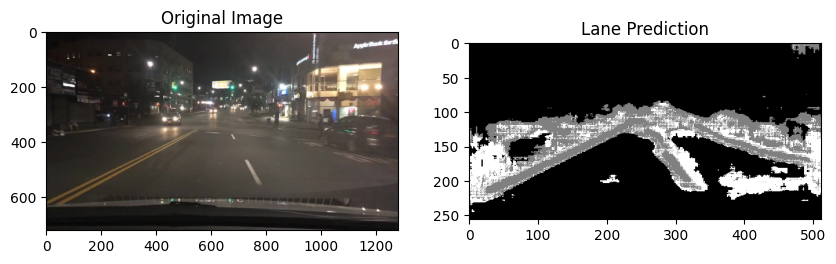

In [ ]:
import torch
from model.lanenet.LaneNet import LaneNet
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Define the transformation for inference
transform = A.Compose([
    A.Resize(256, 512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LaneNet(arch='ENet')
model.load_state_dict(torch.load('/content/drive/My Drive/Nightdataset/models/mytrained_lanenet_decoder_instance1.pth', map_location=device))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Function to perform inference on a single image
def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)

    # Apply the transformation
    augmented = transform(image=image)
    image = augmented['image'].unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        output = model(image)
        instance_seg_logits = output['instance_seg_logits']
        preds = torch.argmax(torch.softmax(instance_seg_logits, dim=1), dim=1)

    return preds.cpu().numpy(), instance_seg_logits.cpu().numpy()

# Function to visualize predictions
def visualize_predictions(image_path, prediction):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction[0], cmap='gray')
    plt.title('Lane Prediction')

    plt.show()

# Example usage
image_path = '/content/drive/My Drive/Nightdataset/newdata1/37151185-cad9ec56.jpg'
prediction, logits = predict(image_path)
print("Prediction Shape:", prediction.shape)
print("Logits Shape:", logits.shape)

visualize_predictions(image_path, prediction)


Use ENet as backbone
Prediction Shape: (1, 256, 512)
Logits Shape: (1, 3, 256, 512)


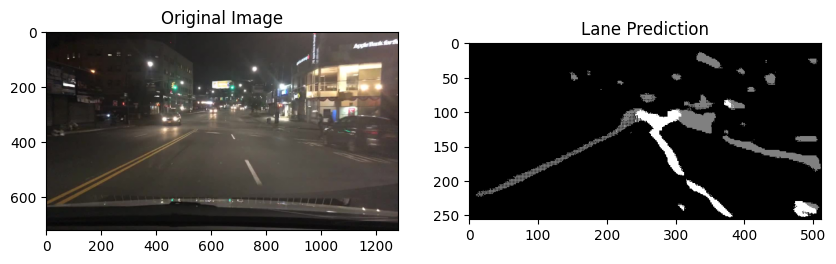

In [ ]:
import torch
from model.lanenet.LaneNet import LaneNet
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Define the transformation for inference
transform = A.Compose([
    A.Resize(256, 512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LaneNet(arch='ENet')
model.load_state_dict(torch.load('/content/drive/My Drive/Nightdataset/original_model/original_trained_model.pth', map_location=device))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Function to perform inference on a single image
def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)

    # Apply the transformation
    augmented = transform(image=image)
    image = augmented['image'].unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        output = model(image)
        instance_seg_logits = output['instance_seg_logits']
        preds = torch.argmax(torch.softmax(instance_seg_logits, dim=1), dim=1)

    return preds.cpu().numpy(), instance_seg_logits.cpu().numpy()

# Function to visualize predictions
def visualize_predictions(image_path, prediction):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction[0], cmap='gray')
    plt.title('Lane Prediction')

    plt.show()

# Example usage
image_path = '/content/drive/My Drive/Nightdataset/newdata1/37151185-cad9ec56.jpg'
prediction, logits = predict(image_path)
print("Prediction Shape:", prediction.shape)
print("Logits Shape:", logits.shape)

visualize_predictions(image_path, prediction)


Use ENet as backbone
Prediction Shape: (1, 256, 512)
Logits Shape: (1, 3, 256, 512)


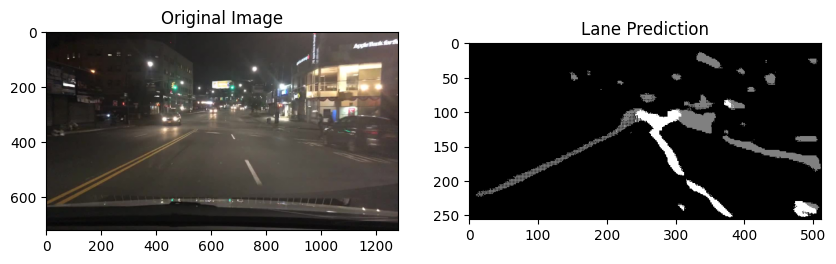

In [ ]:
import torch
from model.lanenet.LaneNet import LaneNet
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Define the transformation for inference
transform = A.Compose([
    A.Resize(256, 512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LaneNet(arch='ENet')
model.load_state_dict(torch.load('/content/drive/My Drive/Nightdataset/best_model.pth', map_location=device))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Function to perform inference on a single image
def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)

    # Apply the transformation
    augmented = transform(image=image)
    image = augmented['image'].unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        output = model(image)
        instance_seg_logits = output['instance_seg_logits']
        preds = torch.argmax(torch.softmax(instance_seg_logits, dim=1), dim=1)

    return preds.cpu().numpy(), instance_seg_logits.cpu().numpy()

# Function to visualize predictions
def visualize_predictions(image_path, prediction):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction[0], cmap='gray')
    plt.title('Lane Prediction')

    plt.show()

# Example usage
image_path = '/content/drive/My Drive/Nightdataset/newdata1/37151185-cad9ec56.jpg'
prediction, logits = predict(image_path)
print("Prediction Shape:", prediction.shape)
print("Logits Shape:", logits.shape)

visualize_predictions(image_path, prediction)


Prediction Shape: (1, 256, 512)
Logits Shape: (1, 3, 256, 512)


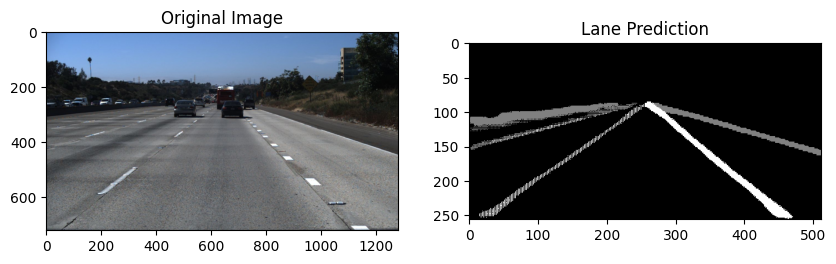

In [ ]:
# Example usage
image_path = '/content/drive/My Drive/TusimpleDataset/test/images/0601_1495492790542154496.jpg'
prediction, logits = predict(image_path)
print("Prediction Shape:", prediction.shape)
print("Logits Shape:", logits.shape)

visualize_predictions(image_path, prediction)